## Classifying facial expressions

In [116]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 10

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [117]:
#Loading the dataset and preprocessing
dataset = torchvision.datasets.ImageFolder(root = '/content/Facial_Expressions_Data/MyDrive/Facial_Expressions_Data-20240219T035709Z-001/Facial_Expressions_Data',
                                           transform = transforms.Compose([
                                                  transforms.RandomRotation(30),
                                                  transforms.Resize((32,32)),
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.ToTensor(),
                                                  transforms.Grayscale(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),)

total_size = len(dataset)
train_size = int(0.9*total_size)
test_size = total_size - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size,test_size])


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

 LeNet - 5

  LeNet5 has 5 layers with two convolutional and three fully connected layers. Let's start with the input. LeNet5 accepts as input a greyscale image of 32x32, indicating that the architecture is not suitable for RGB images (multiple channels).

In [118]:
#Defining the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [119]:
model = LeNet5(num_classes).to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

In [120]:
total_step = len(train_loader)
losses = []
for epoch in range(num_epochs):
    epoch_losses = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    # Calculate the average loss for the epoch

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        		           .format(epoch+1, num_epochs, i+1, total_step, avg_loss))
    losses.append(avg_loss)  # Append the average loss for this epoch to the losses list

Epoch [1/10], Step [15/15], Loss: 1.8511
Epoch [2/10], Step [15/15], Loss: 1.5554
Epoch [3/10], Step [15/15], Loss: 1.5600
Epoch [4/10], Step [15/15], Loss: 1.4976
Epoch [5/10], Step [15/15], Loss: 1.4973
Epoch [6/10], Step [15/15], Loss: 1.4763
Epoch [7/10], Step [15/15], Loss: 1.4492
Epoch [8/10], Step [15/15], Loss: 1.4386
Epoch [9/10], Step [15/15], Loss: 1.4479
Epoch [10/10], Step [15/15], Loss: 1.4350


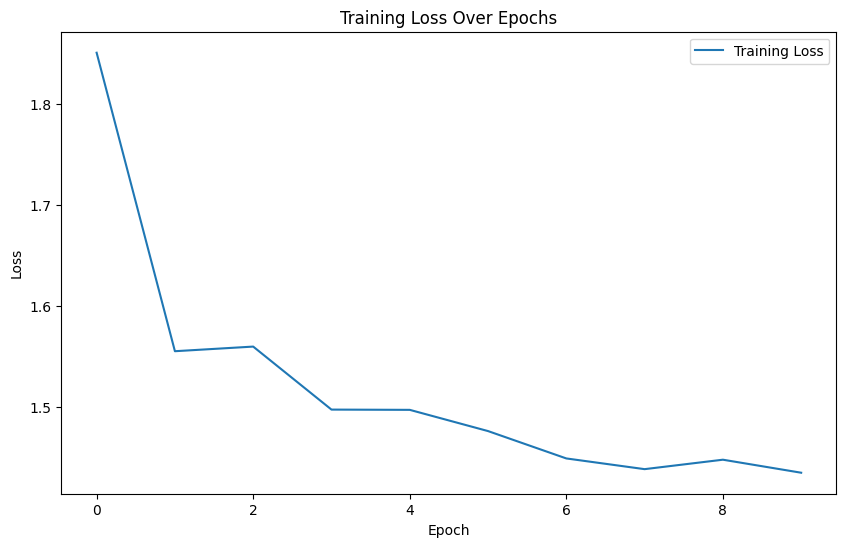

In [121]:
import matplotlib.pyplot as plt

# After all epochs, plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


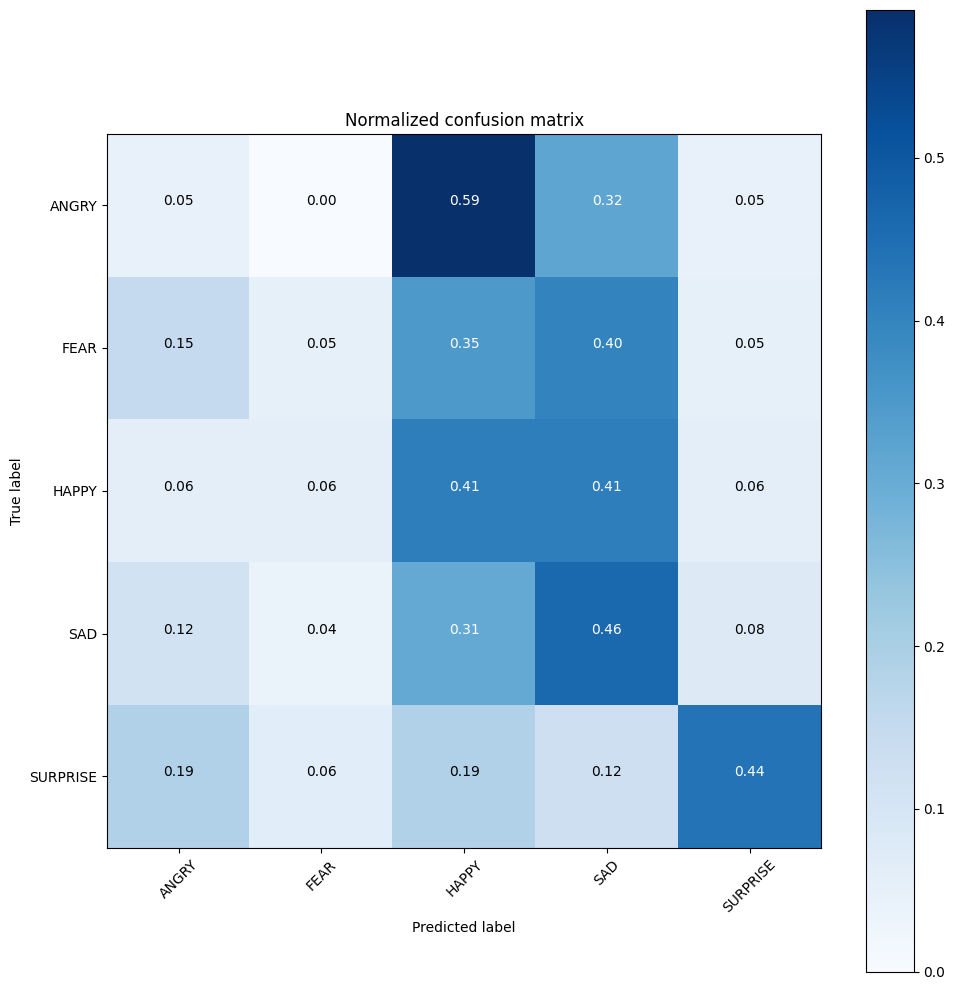

In [122]:
import numpy as np
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predictions
y_pred = []
y_true = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        output = model(data.to(device))
        pred = output.argmax(dim=1, keepdim=True)
        y_pred.extend(pred.view_as(target))
        y_true.extend(target)

y_pred = [y.item() for y in y_pred]
y_true = [y.item() for y in y_true]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=["ANGRY","FEAR","HAPPY","SAD","SURPRISE"], normalize=True, title='Normalized confusion matrix')
plt.show()

<ipython-input-128-9652981d73c4>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(i+1)


Accuracy of the network on the 10000 test images: 34.65346534653465 %


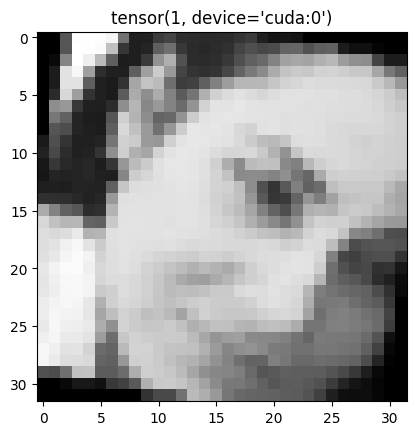

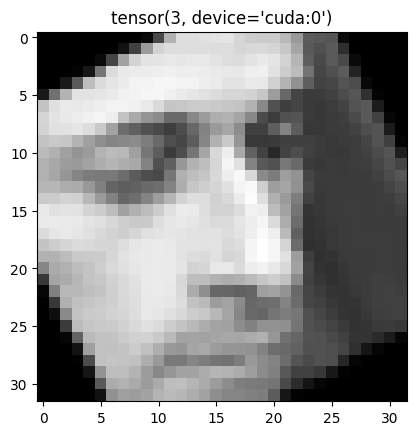

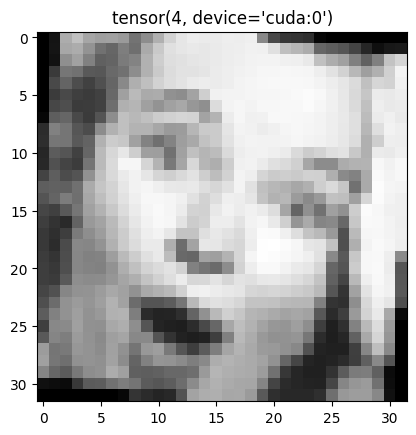

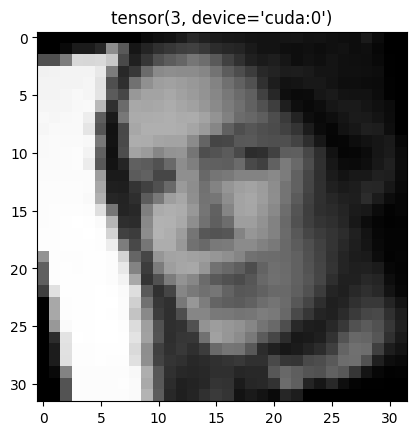

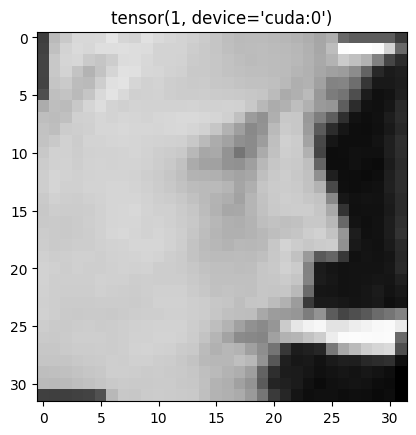

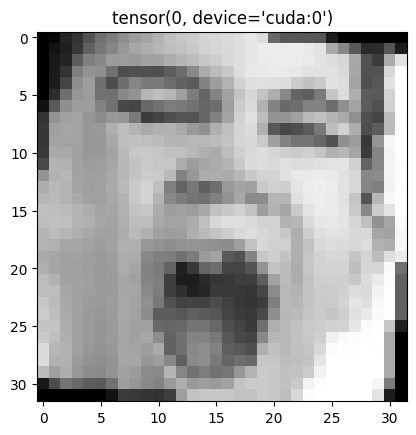

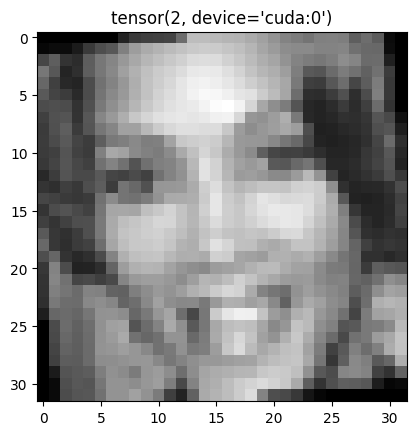

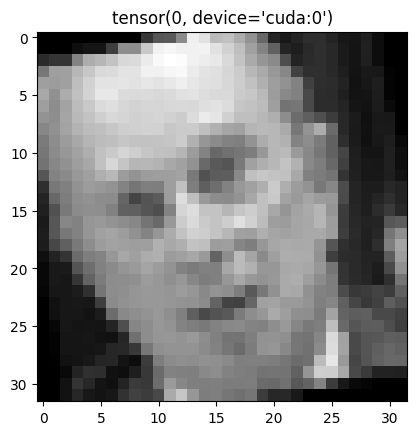

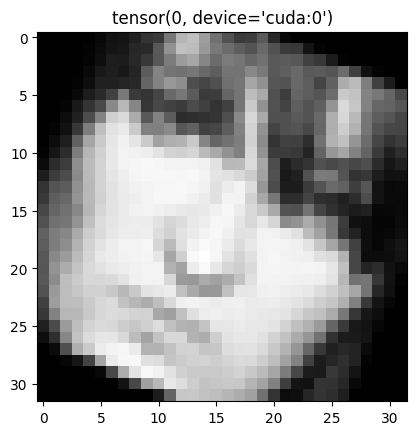

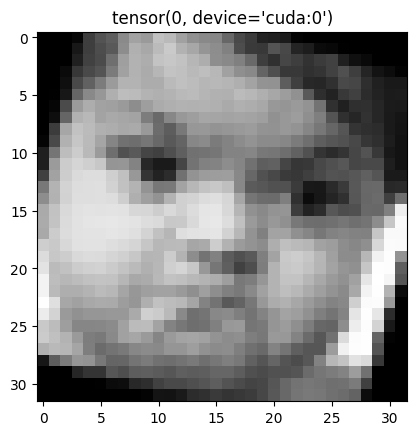

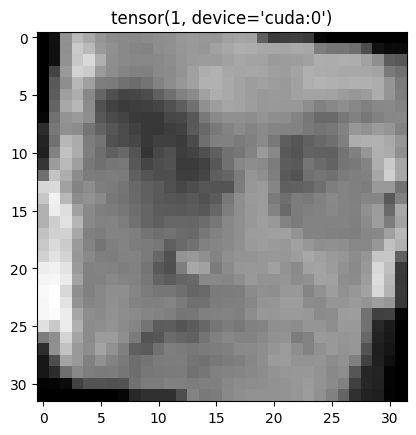

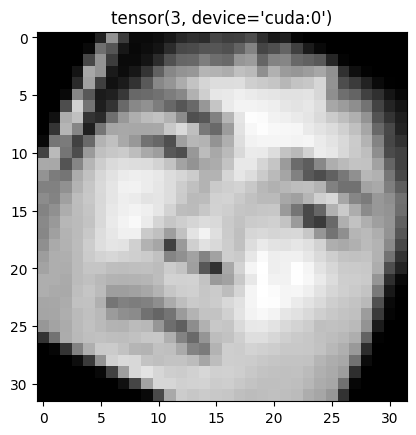

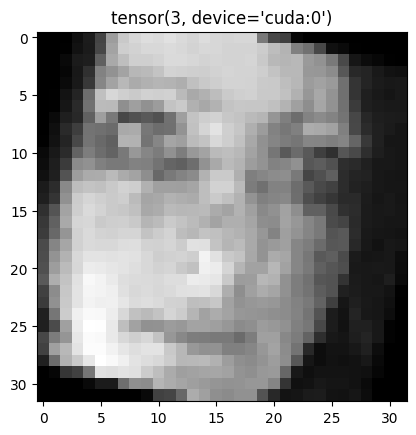

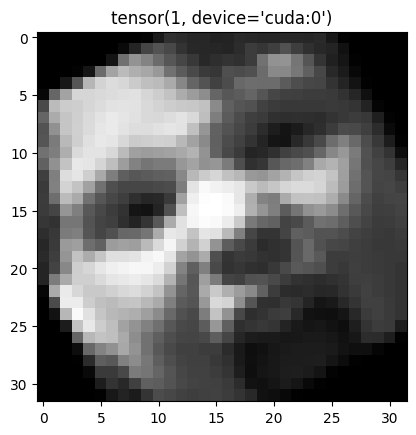

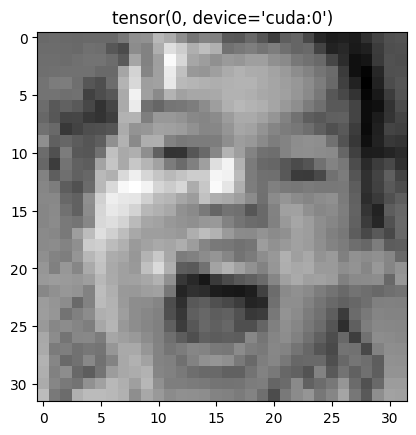

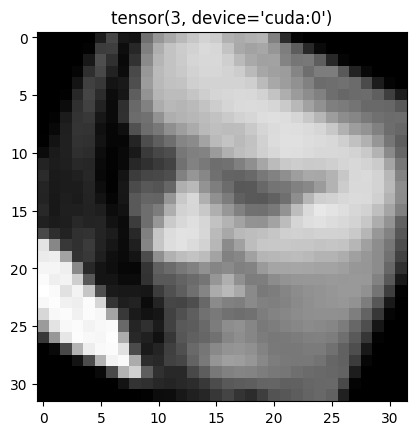

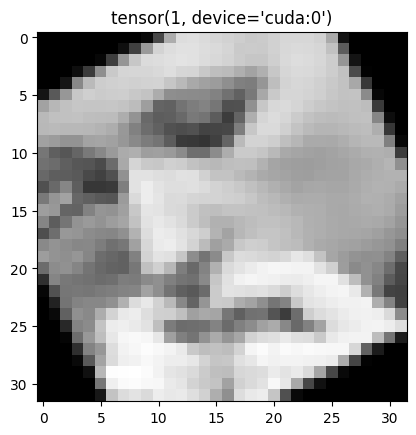

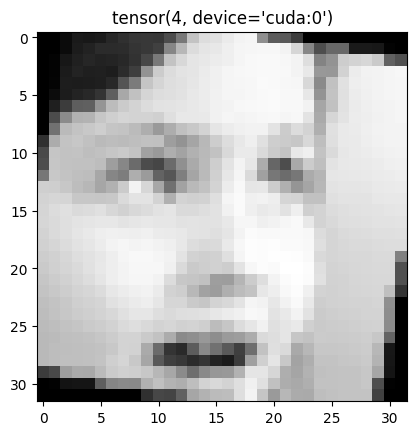

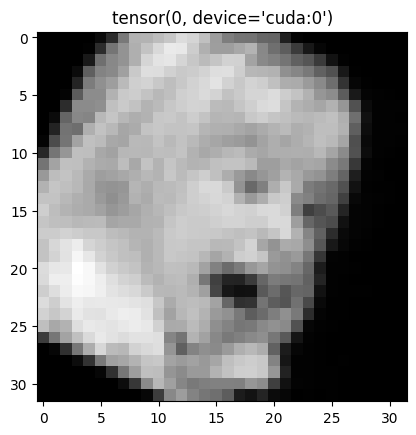

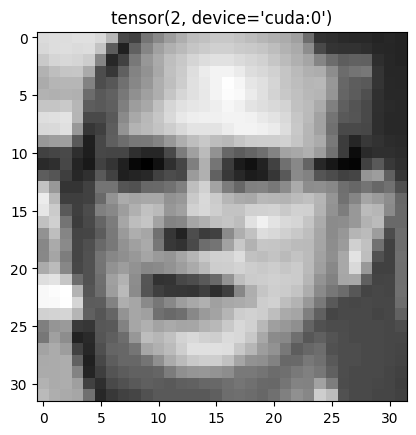

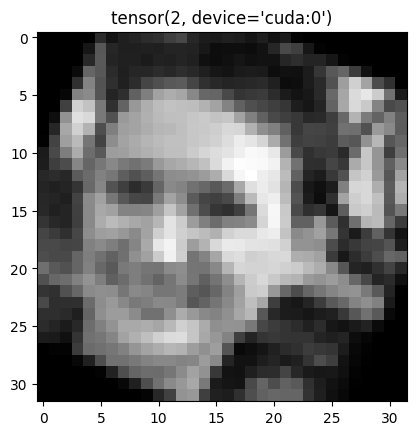

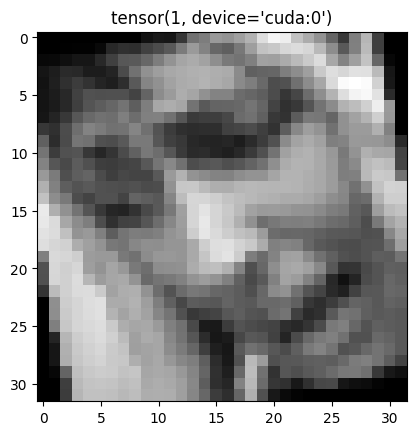

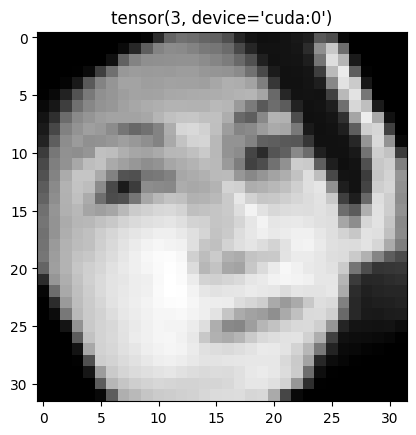

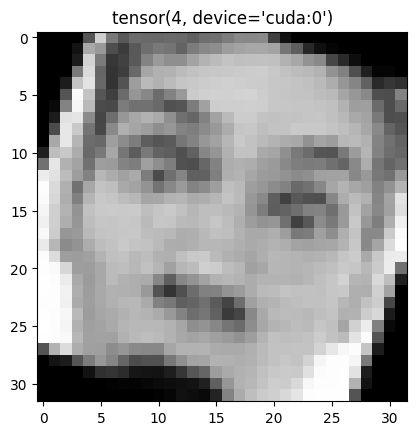

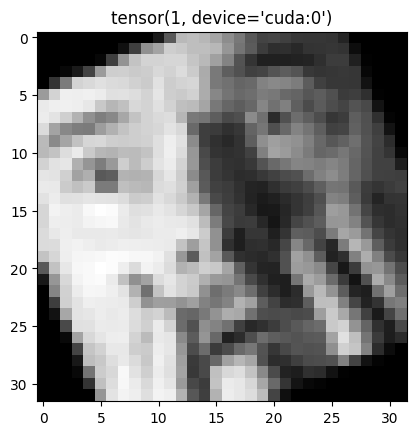

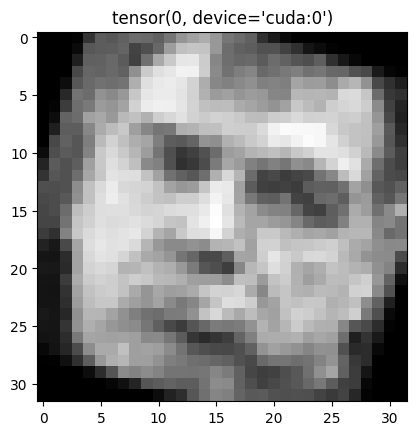

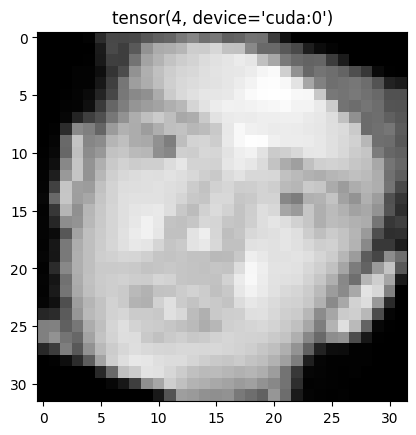

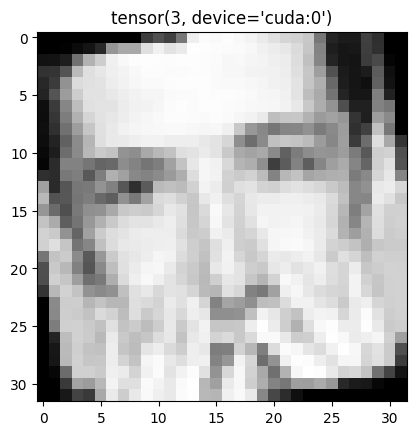

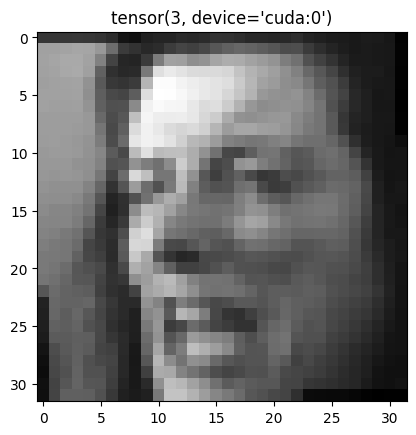

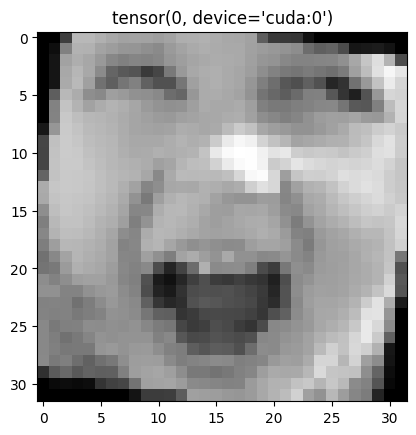

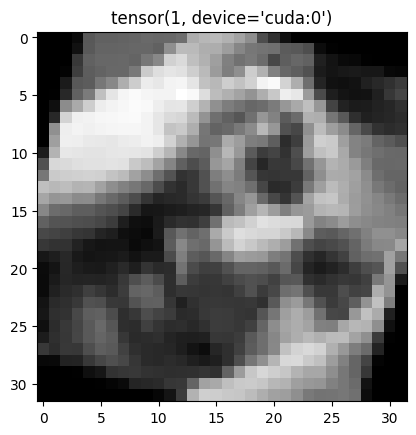

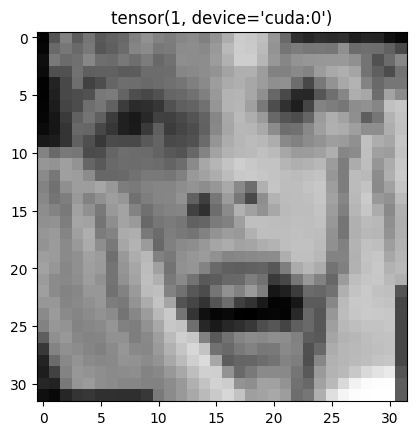

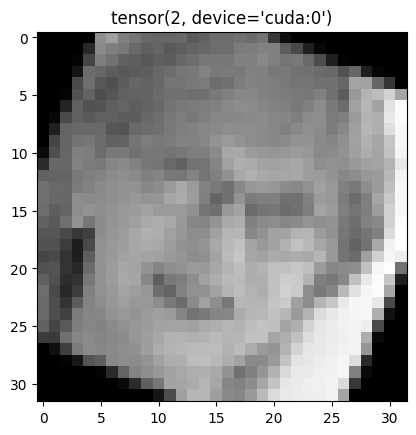

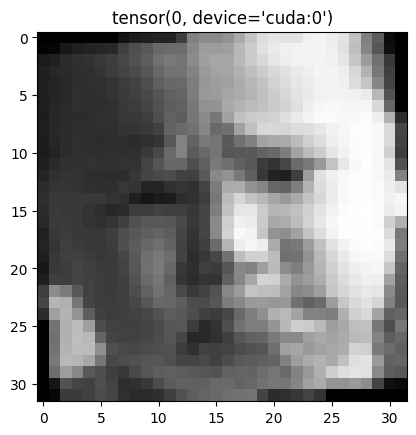

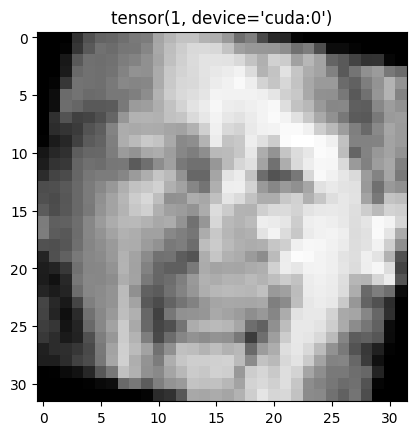

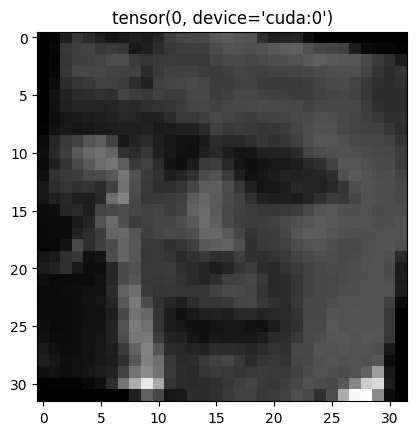

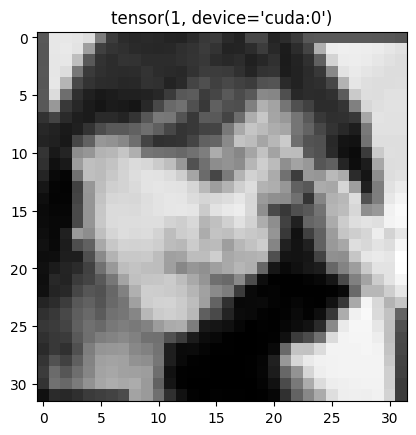

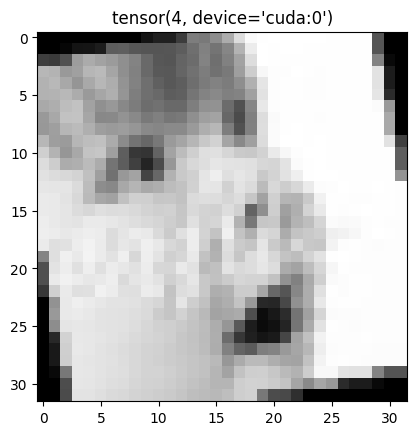

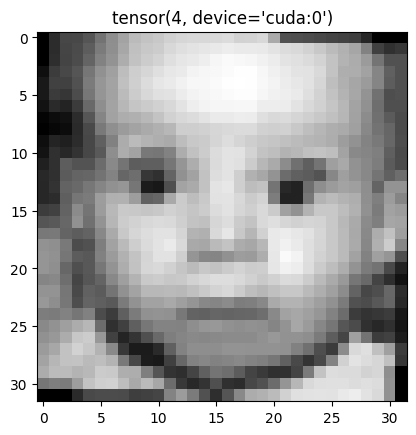

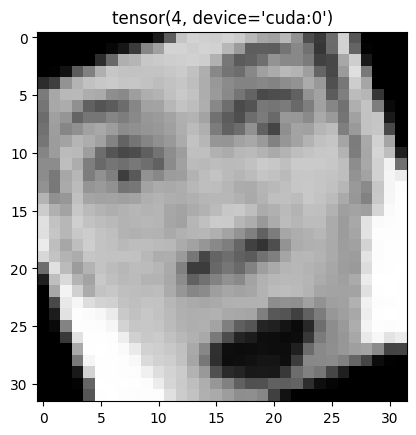

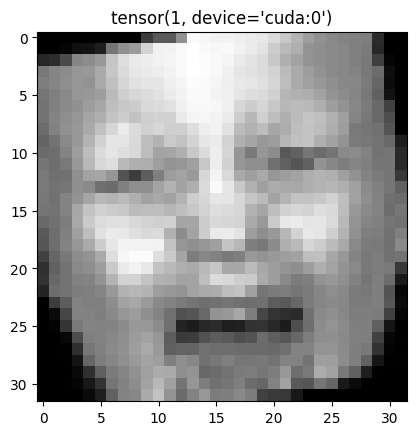

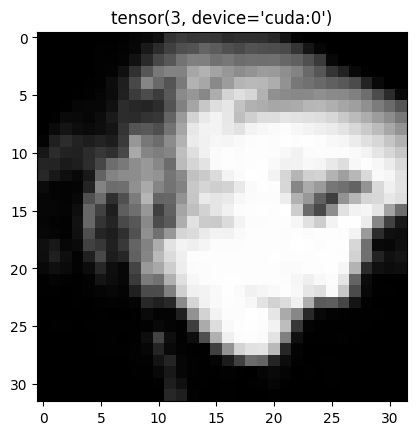

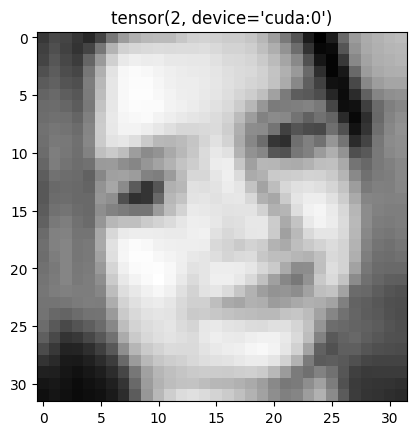

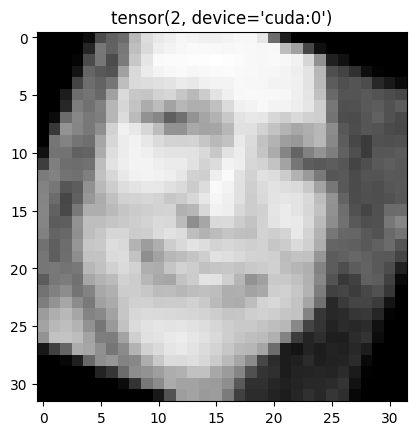

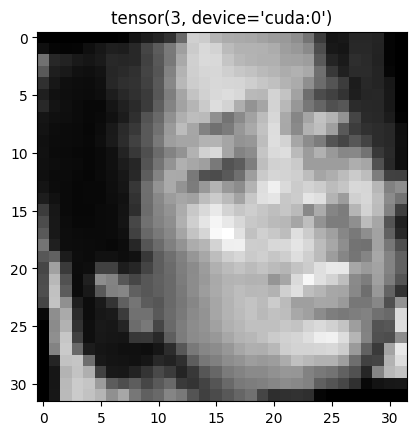

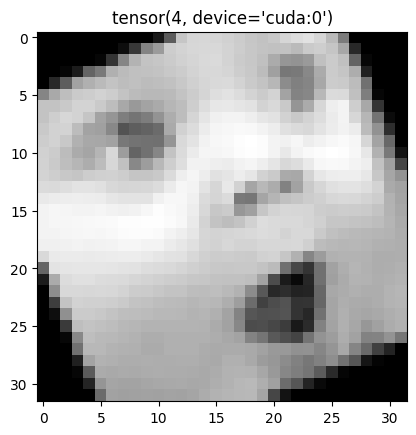

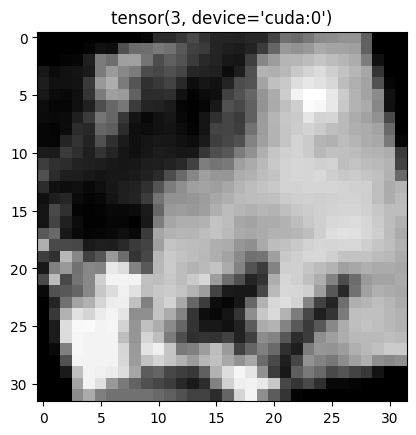

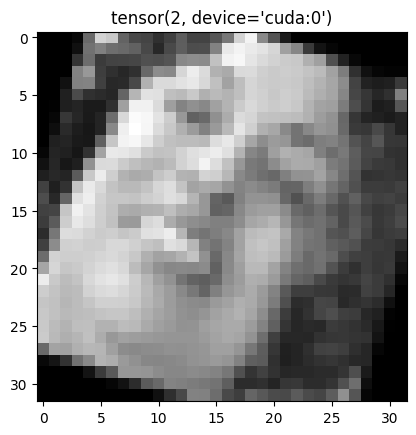

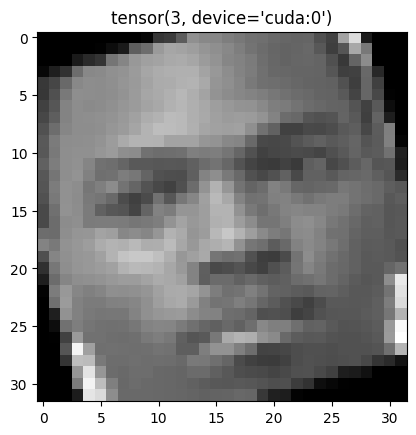

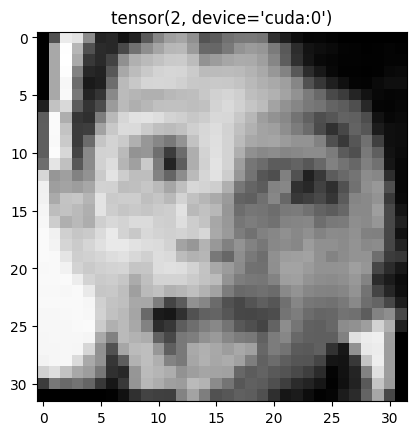

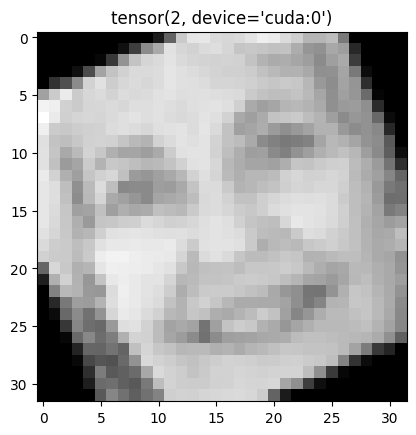

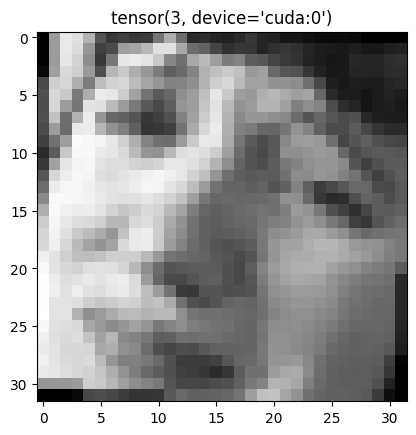

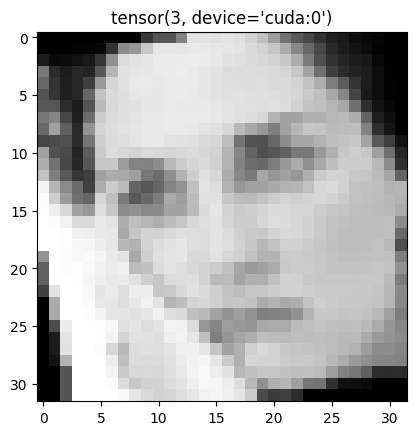

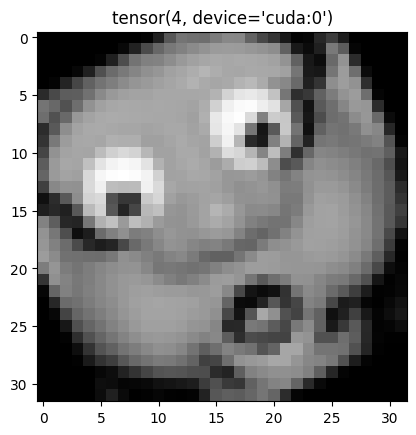

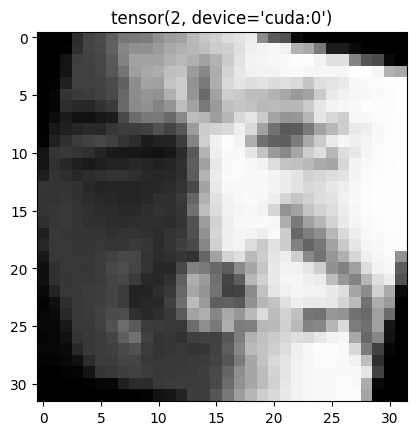

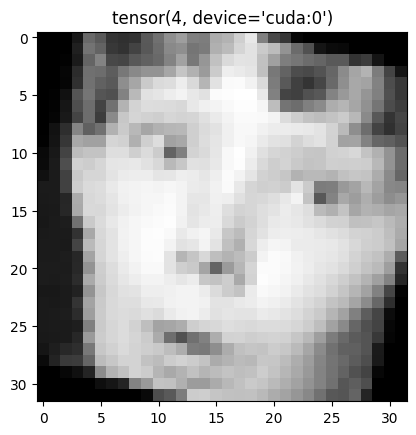

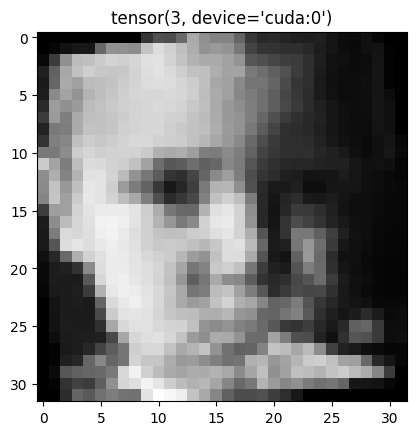

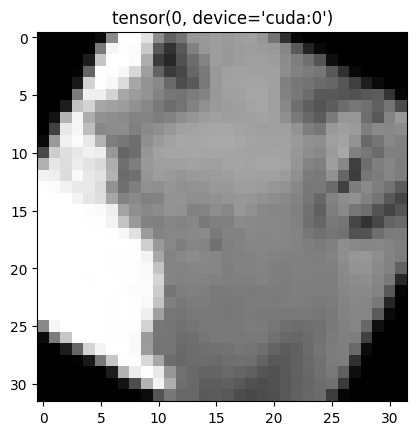

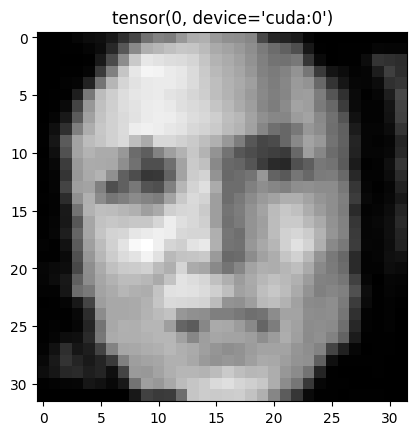

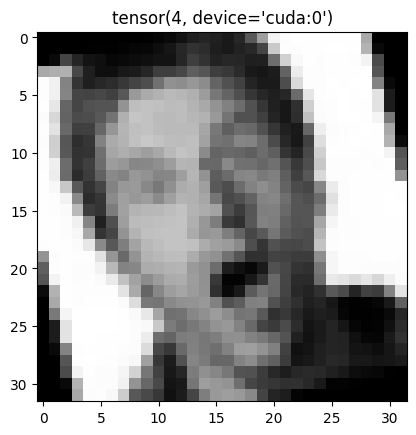

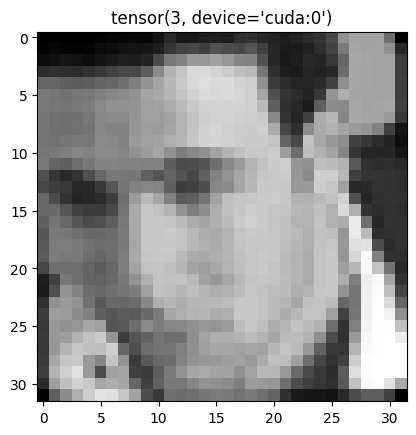

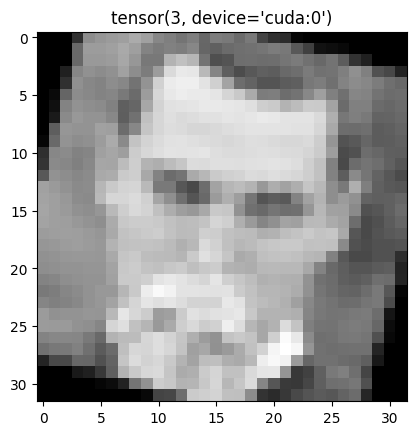

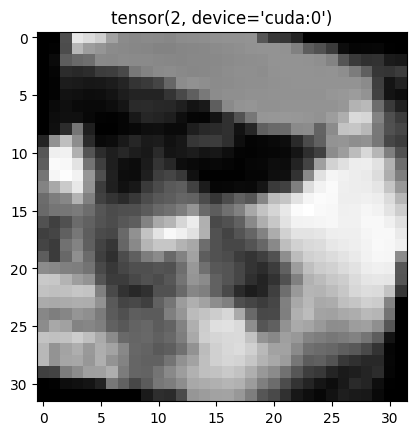

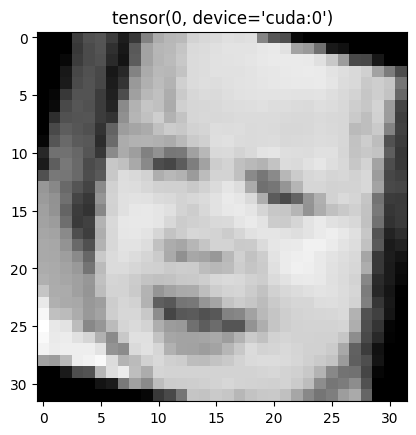

In [128]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(len(labels)):
          plt.imshow(images[i][0].cpu(),cmap="gray")
          plt.title(labels[i])
          plt.figure(i+1)


    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))


AlexNet

Firstly, it operated with 3-channel images that were (224x224x3) in size. It used max pooling along with ReLU activations when subsampling. The kernels used for convolutions were either 11x11, 5x5, or 3x3 while kernels used for max pooling were 3x3 in size.

In [132]:
#Loading the dataset and preprocessing
dataset = torchvision.datasets.ImageFolder(root = '/content/Facial_Expressions_Data/MyDrive/Facial_Expressions_Data-20240219T035709Z-001/Facial_Expressions_Data',
                                           transform = transforms.Compose([
                                                  transforms.RandomRotation(30),
                                                  transforms.Resize((227,227)),
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),)

total_size = len(dataset)
train_size = int(0.9*total_size)
test_size = total_size - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size,test_size])


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [133]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [134]:
num_classes = 5
num_epochs = 10
batch_size = 64
learning_rate = 0.005

model = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)


# Train the model
total_step = len(train_loader)

Epoch [1/10], Step [15/15], Loss: 1.6811
Epoch [2/10], Step [15/15], Loss: 1.6556
Epoch [3/10], Step [15/15], Loss: 1.6477
Epoch [4/10], Step [15/15], Loss: 1.5669
Epoch [5/10], Step [15/15], Loss: 1.5776
Epoch [6/10], Step [15/15], Loss: 1.5447
Epoch [7/10], Step [15/15], Loss: 1.5258
Epoch [8/10], Step [15/15], Loss: 1.5258
Epoch [9/10], Step [15/15], Loss: 1.5475
Epoch [10/10], Step [15/15], Loss: 1.4981


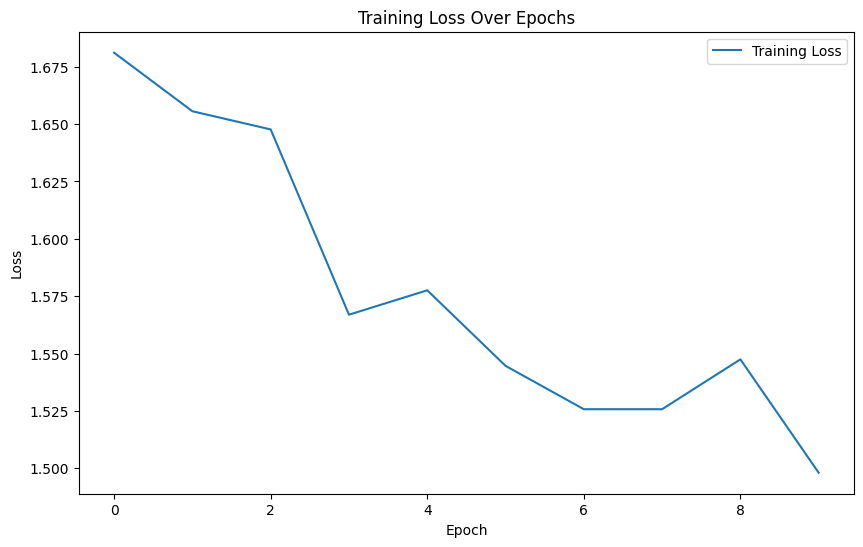

In [135]:

total_step = len(train_loader)

losses = []  # List to store loss values
for epoch in range(num_epochs):
    epoch_losses = []  # List to store losses for each epoch
    for i, (images, labels) in enumerate(train_loader):

        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

  # Calculate the average loss for the epoch
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, avg_loss))
    losses.append(avg_loss)  # Append the average loss for this epoch to the losses list

# After all epochs, plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [139]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 32.67326732673267 %


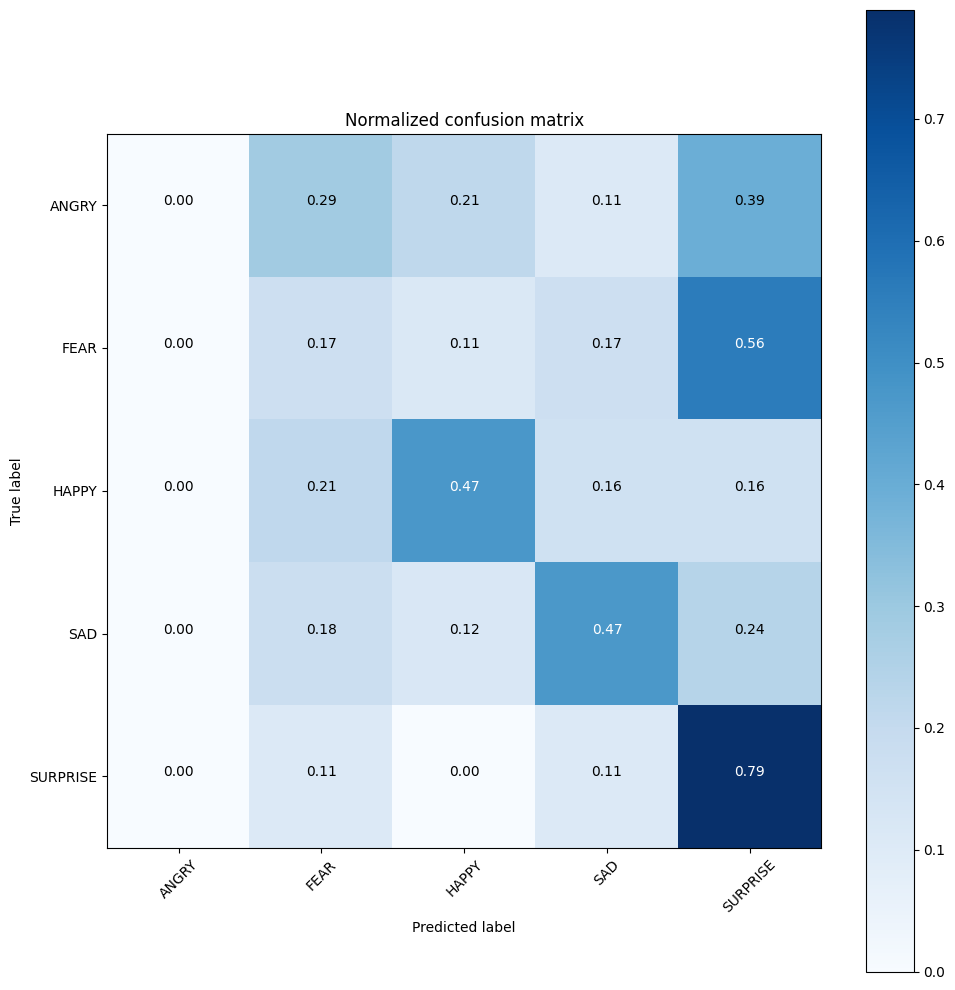

In [110]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predictions
y_pred = []
y_true = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        output = model(data.to(device))
        pred = output.argmax(dim=1, keepdim=True)
        y_pred.extend(pred.view_as(target))
        y_true.extend(target)

y_pred = [y.item() for y in y_pred]
y_true = [y.item() for y in y_true]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes=["ANGRY","FEAR","HAPPY","SAD","SURPRISE"], normalize=True, title='Normalized confusion matrix')
plt.show()

 ResNet

Accuracy of the network on the 10000 test images: 37.62376237623762 %


VGGNet

Inception v3